In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def two_dimensional_peak(p_x, p_y, std, a, size=10):
    activations = np.zeros((size, size))
    for x in range(size):
        for y in range(size):
            activations[x,y] = a * np.exp(-0.5*((x-p_x)**2/std**2 + \
                                                (y-p_y)**2/std**2))

    return activations

def gauss_kernel_fn(d, c, s):
    return c * np.exp(- d**2 / (2 * s**2)) 

def absSigmoid(x, beta=100):
    return 0.5 * (1 + beta * x) / (1 + beta * np.abs(x))  + 0.5 # in cedar no + 0.5 at the end

def pad_flat_matrix(matrix_flat, dims, sizes, mode):
    if mode == 'cyclic':
        pad_mode = 'wrap'
    elif mode == 'zero-filled borders':
        pad_mode = 'constant'
    else: 
        print('Padding mode not known!')
        return matrix_flat
        
    if dims == 1:
            matrix_padded = np.pad(matrix_flat, pad_width=int(sizes[0]/2), mode=pad_mode)

    if dims == 2:
        matrix_padded = np.pad(matrix_flat.reshape(sizes), 
                                 pad_width=((int(sizes[0]/2), int(sizes[0]/2)),
                                            (int(sizes[1]/2), int(sizes[1]/2))),
                                 mode=pad_mode)

    if dims == 3:
        matrix_padded = np.pad(matrix_flat.reshape(sizes), 
                                 pad_width=((int(sizes[0]/2), int(sizes[0]/2)),
                                            (int(sizes[1]/2), int(sizes[2]/2)),
                                            (int(sizes[2]/2), int(sizes[1]/2))),
                                 mode=pad_mode)

    return matrix_padded.flatten()

In [3]:
class NeuralField(object):
    def __init__(self, sizes, h, tau, c_glob, beta, normalize, kernel_fn, border_type=None):
        self.sizes = sizes
        self.h = h
        self.tau = tau
        self.c_glob = c_glob
        self.beta = beta
        self.kernel_fn = kernel_fn
        self.u = np.ones(np.product(sizes)) * self.h
        self.normalize = normalize
        
        self.lateral_interaction = []
        self.kernels = []
        self.sigmoided_activation = []
        self.cnt = 0
        self.border_type = border_type # in the end should be 'zero-filled borders' or
                                       # 'cyclic', now additionally add None for not doing
                                       # any padding (to have a comparison)
        
    def recurrence(self, x):
        dims = len(self.sizes)
        integrals = np.zeros(len(x))
        gs = absSigmoid(x, self.beta)
        g_sum = np.sum(gs)
        
        
        if self.border_type in ['zero-filled borders', 'cyclic']:
            kernel_sizes = np.array(self.sizes)*2
            gs_padded = pad_flat_matrix(gs, dims, self.sizes, self.border_type)
            
            if self.cnt == 0:
                current_kernels = []
            for i in range(len(x)):
#                 kernel = np.zeros(np.product(kernel_sizes))
                if dims == 1:
                    x_pos = i
                elif dims == 2:
                    x_pos = int(i / self.sizes[1]) + int(self.sizes[0] / 2)
                    y_pos = int(i % self.sizes[1] + self.sizes[1] / 2)
                
                    x_range = np.arange(self.sizes[0]*2)
                    y_range = np.arange(self.sizes[1]*2)

                    grid_x, grid_y = np.meshgrid(x_range,y_range)

                    dx = np.sqrt((grid_x-x_pos)**2 + (grid_y-y_pos)**2)
#                     print(dx.shape)
                
#                 for j in range(np.product(kernel_sizes)):
#                     if dims == 1:
#                         x_2_pos = j
#                         d = x_pos - x_2_pos
#                     elif dims == 2:
#                         x_2_pos = int(j / kernel_sizes[1])
#                         y_2_pos = j % kernel_sizes[1]
#                         d = np.sqrt((y_pos - y_2_pos)**2 + (x_pos - x_2_pos)**2)
                    
                    kernel = self.kernel_fn(dx).flatten()
                    
                
                if self.cnt == 0:
                    current_kernels.append(kernel)
                if self.normalize:
                    kernel /= np.sum(kernel) # could normalize by dividing only by the sum
                                             # of the kernel part inside the neural field
#                 print(kernel.shape, gs_padded.shape)
                integrals[i] = np.sum(np.multiply(kernel, gs_padded))
                
            self.example_sigmoid_activation = [gs.reshape(self.sizes), gs_padded.reshape(kernel_sizes)]
               
        # no dealing with border, just cutting at edge
        elif self.border_type is None:
            if self.cnt == 0:
                current_kernels = []
                
            for i in range(len(x)):
                kernel = np.zeros(len(x))
                if dims == 0:
                    # don't know what should be done in this case
                    continue
                elif dims == 1:
                    x_pos = i
                elif dims == 2:
                    x_pos = int(i / self.sizes[1])
                    y_pos = i % self.sizes[1]
                elif dims == 3:
                    x_pos = int(i / (self.sizes[1]*self.sizes[2]))
                    y_pos = int((i % (self.sizes[1]*self.sizes[2])) / self.sizes[2])
                    z_pos = (i % (self.sizes[1]*self.sizes[2])) % self.sizes[2]
                for j in range(len(x)):
                    if dims == 1:
                        x_2_pos = j
                        d = x_pos - x_2_pos
                    elif dims == 2:
                        x_2_pos = int(j / self.sizes[1])
                        y_2_pos = j % self.sizes[1]
                        d = np.sqrt((y_pos - y_2_pos)**2 + (x_pos - x_2_pos)**2)
                    elif dims == 3:
                        x_2_pos = int(j / (self.sizes[1]*self.sizes[2]))
                        y_2_pos = int((j % (self.sizes[1]*self.sizes[2])) / self.sizes[2])
                        z_2_pos = (j % (self.sizes[1]*self.sizes[2])) % self.sizes[2]
                        d = np.sqrt((z_pos - z_2_pos)**2 + (y_pos - y_2_pos)**2 + (x_pos - x_2_pos)**2)
                    k = self.kernel_fn(d)
                    kernel[j] = k

                if self.cnt == 0:
                    current_kernels.append(kernel)
                if self.normalize:
                    kernel /= np.sum(kernel)
                integrals[i] = np.sum(np.multiply(kernel, gs))
                
            self.example_sigmoid_activation = [gs.reshape(self.sizes)]
            
        if self.cnt == 0:
            self.kernels.append(current_kernels)
            self.cnt += 1
        self.lateral_interaction.append([integrals])   
        self.sigmoided_activation.append(gs.reshape(self.sizes))
        
#         print(self.h, integrals.shape, self.c_glob, g_sum, x.shape)
        return self.h + integrals + self.c_glob * g_sum - x    
        
        
    def update(self, t, input):
        # this is what the NeuralField Node will do every time step
        r = self.recurrence(self.u)
        self.u = (r + input) / self.tau  + self.u

        return self.u
        
    def make_node(self):
        # turn the NeuralField into a nengo Node
        return nengo.Node(self.update, size_in=np.product(self.sizes), size_out=np.product(self.sizes))


In [4]:
field_size = 10

tau = 50 
h = -5
c_exc, c_glob = 1, -0.01
std_exc, std_inh = 3, 0.5
beta = 100
normalize = True
border_type = 'cyclic' # can be None, 'cyclic' or 'zero-filled borders'

model = nengo.Network()
with model:
    # peak at (3,4)
    s = nengo.Node(list(two_dimensional_peak(1,1,std=2,a=6.5,size=field_size).flatten()))
    
    kernel_fn = lambda d: gauss_kernel_fn(d, c_exc, std_exc)
    neural_field = NeuralField(sizes=[field_size, field_size], h=h, tau=tau, c_glob=c_glob, 
                               beta=beta, kernel_fn=kernel_fn, normalize=True, 
                               border_type=border_type)
    u = neural_field.make_node()
    
    
    nengo.Connection(s, u)
                                                      
    activation_probe = nengo.Probe(u)
    external_input_probe = nengo.Probe(s)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(0.3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

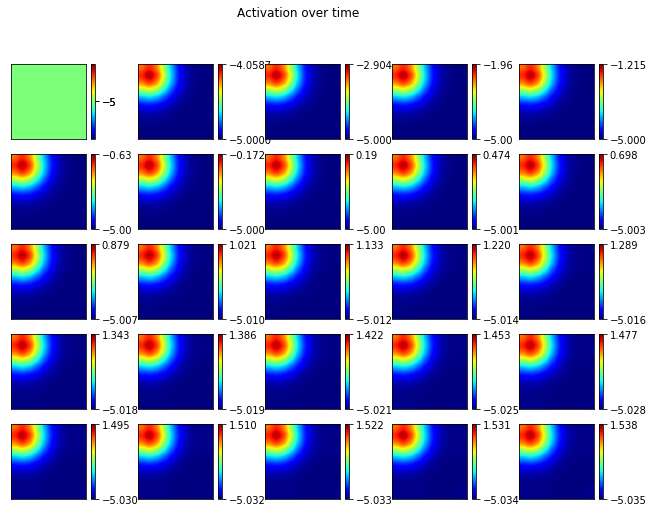

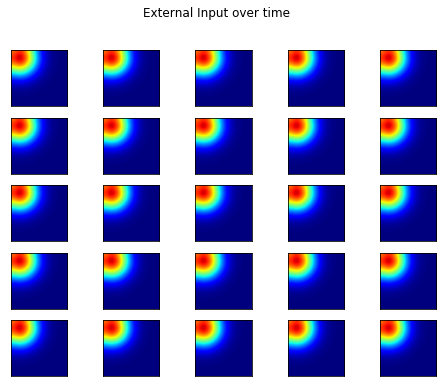

In [5]:
plt.figure(figsize=(11,8))
freq = 5

plt.suptitle('Activation over time')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    act = sim.data[activation_probe][int(sim.data[activation_probe].shape[0]/25*i),:]
    plt.imshow(act.reshape(field_size,field_size), cmap="jet", interpolation='gaussian' )
    plt.colorbar(ticks=[np.min(act), np.max(act)])
    
plt.figure(figsize=(8,6))
plt.suptitle('External Input over time')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sim.data[external_input_probe][i*freq,:].reshape(field_size,field_size), cmap="jet", 
               interpolation='bicubic')
    
plt.show()

In [6]:
print("Neural Field Activation: %.2f %.2f" %(np.min(sim.data[activation_probe]), np.max(sim.data[activation_probe])))    
print("Input Activation: %.2f %.2f" %(np.min(sim.data[external_input_probe]), np.max(sim.data[external_input_probe])))

Neural Field Activation: -5.04 1.54
Input Activation: 0.00 6.50


# Plot activation over time for different taus

Number for cedar are noted down from a cedar simulation with step size 5ms. The number written down is the maximum of the bar of the current activation at each step, so not an accurate number of the actual maximum.

The nengo numbers are saved from a run with the corresponding tau value (stepsize also 5ms). If the tau value of the current run is 50, 100 or 2000, it the current values override the saved ones. 

In [7]:
# Max activations for different tau values with nengo --> saved from a run
print(sim.data[activation_probe].shape)
time_courses_nengo = {}
# activation values of every 5ms
time_courses_nengo['2000'] = [-5.0, -4.99, -4.98, -4.96, -4.949, -4.933, -4.917, -4.901,
                              -4.885, -4.869, -4.853, -4.837, -4.822, -4.806, -4.79, -4.774, 
                              -4.759, -4.743, -4.727, -4.712, -4.696, -4.681, -4.666, -4.650, 
                              -4.635, -4.619, -4.604, -4.589, -4.574, -4.559, -4.543, -4.528, 
                              -4.513, -4.498, -4.483, -4.468, -4.453, -4.438, -4.424, -4.409, 
                              -4.394, -4.379, -4.365, -4.350, -4.335, -4.321, -4.306, -4.292, 
                              -4.277, -4.263, -4.249, -4.234, -4.220, -4.206, -4.191, -4.177, 
                              -4.163, -4.149, -4.135, -4.121, -4.107, -4.093, -4.079, -4.065, 
                              -4.051, -4.037, -4.023, -4.009, -3.99, -3.982, -3.968, -3.954, 
                              -3.941, -3.927, -3.91, -3.9, -3.887, -3.873, -3.860, -3.846, 
                              -3.833, -3.820, -3.806, -3.793, -3.780, -3.767, -3.754, -3.740, 
                              -3.727, -3.714, -3.701, -3.688, -3.675, -3.662, -3.650, -3.637, 
                              -3.624, -3.611, -3.598, -3.586, -3.573, -3.560, -3.548, -3.535, 
                              -3.522, -3.510, -3.497, -3.485, -3.472, -3.460, -3.448, -3.4356, 
                              -3.423, -3.411, -3.398, -3.386, -3.374, -3.362, -3.350, -3.337]
time_courses_nengo['100'] = [-5.0, -4.862, -4.617, -4.342, -4.064, -3.795, -3.537, -3.290, 
                             -3.056, -2.832, -2.620, -2.418, -2.226, -2.043, -1.870, -1.704, 
                             -1.547, -1.398, -1.256, -1.121, -0.992, -0.870, -0.754, -0.643, 
                             -0.538, -0.438, -0.343, -0.253, -0.167, -0.085, -0.007, 0.067, 
                             0.138, 0.205, 0.269, 0.330, 0.388, 0.444, 0.496, 0.546, 0.594, 
                             0.640, 0.684, 0.727, 0.768, 0.807, 0.844, 0.880, 0.913, 0.945, 
                             0.976, 1.004, 1.032, 1.058, 1.083, 1.106, 1.129, 1.150, 1.171, 
                             1.190, 1.209, 1.226, 1.243, 1.259, 1.274, 1.288, 1.302, 1.315, 
                             1.327, 1.339, 1.351, 1.361, 1.372, 1.382, 1.392, 1.401, 1.411, 
                             1.420, 1.429, 1.438, 1.446, 1.454, 1.462, 1.469, 1.476, 1.483, 
                             1.489, 1.495, 1.500, 1.505, 1.511, 1.515, 1.520, 1.524, 1.528, 
                             1.532, 1.536, 1.540, 1.543, 1.546, 1.549, 1.552, 1.555, 1.558, 
                             1.560, 1.562, 1.565, 1.567, 1.569, 1.571, 1.573, 1.574, 1.576, 
                             1.578, 1.579, 1.581, 1.582, 1.583, 1.585, 1.586]
time_courses_nengo['50'] = [-5.0, -4.729, -4.260, -3.755, -3.267, -2.816, -2.403, -2.029, 
                            -1.690, -1.384, -1.107, -0.856, -0.630, -0.425, -0.240, -0.072, 
                            0.079, 0.217, 0.341, 0.454, 0.556, 0.649, 0.737, 0.816, 0.888, 
                            0.953, 1.012, 1.065, 1.113, 1.156, 1.196, 1.231, 1.264, 1.293, 
                            1.319, 1.343, 1.365, 1.386, 1.405, 1.424, 1.441, 1.457, 1.472, 
                            1.485, 1.497, 1.508, 1.517, 1.526, 1.534, 1.541, 1.548, 1.554, 
                            1.559, 1.564, 1.568, 1.572, 1.575, 1.579, 1.582, 1.584, 1.586, 
                            1.589, 1.591, 1.592, 1.594, 1.595, 1.597, 1.598, 1.599, 1.6, 
                            1.601, 1.601, 1.602, 1.603, 1.603, 1.604, 1.604, 1.605, 1.605, 
                            1.605, 1.606, 1.606, 1.606, 1.607, 1.607, 1.607, 1.607, 1.607, 
                            1.607, 1.607, 1.608, 1.608, 1.608, 1.608, 1.608, 1.608, 1.608, 
                            1.608, 1.608, 1.608, 1.608, 1.608, 1.608, 1.608, 1.608, 1.608, 
                            1.608, 1.608,1.609, 1.609, 1.609,1.609, 1.609, 1.609, 1.609, 
                            1.609, 1.609, 1.609, 1.609, 1.609]

if tau in [50, 100, 2000]:
    print('Using current values!')
    time_courses_nengo['%i' %tau] = np.max(sim.data[activation_probe], axis=1)[::5]

(300, 100)
Using current values!


In [8]:
# Max activation values for different tau values with cedar --> read off of maximum value of colorbar of cedar plots
time_courses_cedar = {}
time_courses_cedar['100'] = [-5, -4.7, -4.4, -4.1, -3.8, -3.5, -3.3, -3, -2.8, -2.6, -2.4, -2.2,
                             -2, -1.8, -1.7, -1.5, -1.4, -1.2, -1.1, -0.95, -0.83, -0.71, -0.6, 
                             -0.5, -0.4, -0.3, -0.21, -0.13, -0.046, 0.031, 0.11, 0.18, 0.24, 
                             0.31, 0.37, 0.42, 0.48, 0.53, 0.58, 0.62, 0.67, 0.71, 0.75, 0.79,
                             0.83, 0.86, 0.9, 0.93, 0.96, 0.99, 1, 1, 1.1, 1.1, 1.1, 1.1, 1.2,
                             1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 
                             1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
                             1.4, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
                             1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
                             1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
time_courses_cedar['50'] = [-5, -4.4, -3.8, -3.2, -2.8, -2.3, -2, -1.6, -1.3, -1, -0.77, -0.54,
                            -0.34, -0.15, 0.013, 0.16, 0.3, 0.42, 0.53, 0.63, 0.71, 0.8, 0.87,
                            0.94, 1, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, 1.4, 1.4,
                            1.4, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
                            1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5]
time_courses_cedar['2000'] = [-5, -5, -5, -5, 
                              -4.9, -4.9, -4.9, -4.9, -4.9, -4.9, 
                              -4.8, -4.8, -4.8, -4.8, -4.8, -4.8, 
                              -4.7, -4.7, -4.7, -4.7, -4.7, -4.7, -4.7,
                              -4.6, -4.6, -4.6, -4.6, -4.6, -4.6, 
                              -4.5, -4.5, -4.5, -4.5, -4.5,
                              -4.5, -4.5, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, 
                              -4.3, -4.3, -4.3, -4.3, -4.3, -4.3, 
                              -4.2, -4.2, -4.2, -4.2, -4.2, -4.2, -4.2,
                              -4.1, -4.1, -4.1, -4.1, -4.1, -4.1, -4.1, -4.1, 
                              -4, -4, -4, -4, -4, -4, -4, 
                              -3.9, -3.9, -3.9, -3.9, -3.9, -3.9, -3.9, 
                              -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8,
                              -3.7, -3.7, -3.7, -3.7, -3.7, -3.7, -3.7, -3.7, 
                              -3.6, -3.6, -3.6, -3.6, -3.6, -3.6]

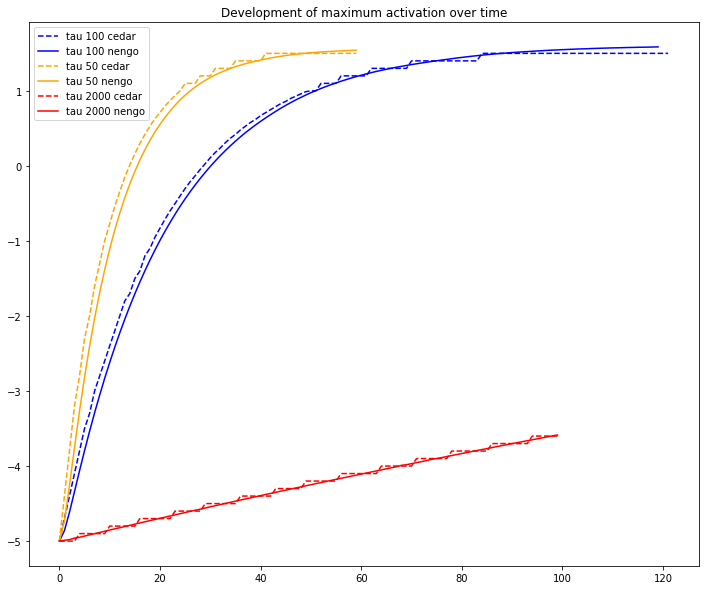

In [9]:
# Plot the development of the maximum activation for different tau values
plt.figure(figsize=(12, 10))
plt.title('Development of maximum activation over time')

plt.plot(time_courses_cedar['100'], '--', c='blue', label='tau 100 cedar')
plt.plot(time_courses_nengo['100'][:len(time_courses_cedar['100'])], c='blue', label='tau 100 nengo')

plt.plot(time_courses_cedar['50'], '--', c='orange', label='tau 50 cedar')
plt.plot(time_courses_nengo['50'][:len(time_courses_cedar['50'])], c='orange', label='tau 50 nengo')

plt.plot(time_courses_cedar['2000'], '--', c='red', label='tau 2000 cedar')
plt.plot(time_courses_nengo['2000'][:len(time_courses_cedar['2000'])], c='red', label='tau 2000 nengo')

plt.legend()
plt.show()

# Plot lateral interaction

Minumum and Maximum lateral interaction: 0.0020 0.1564 
number of kernels: 100


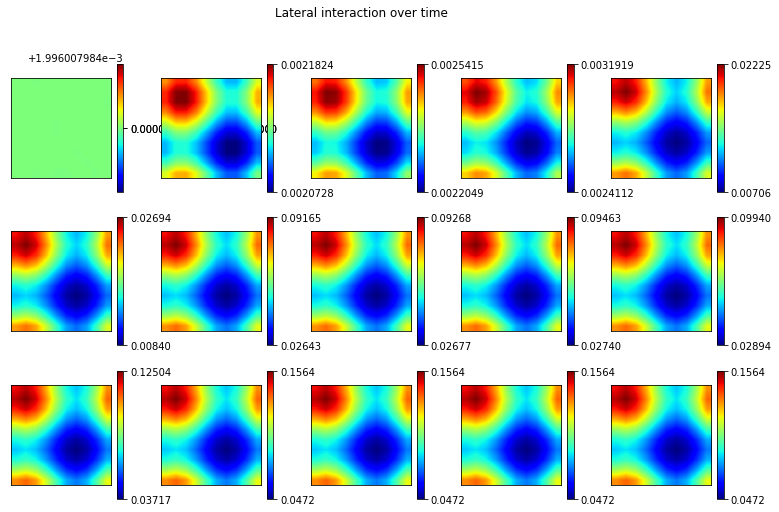

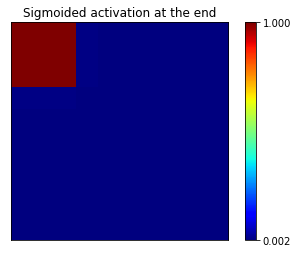

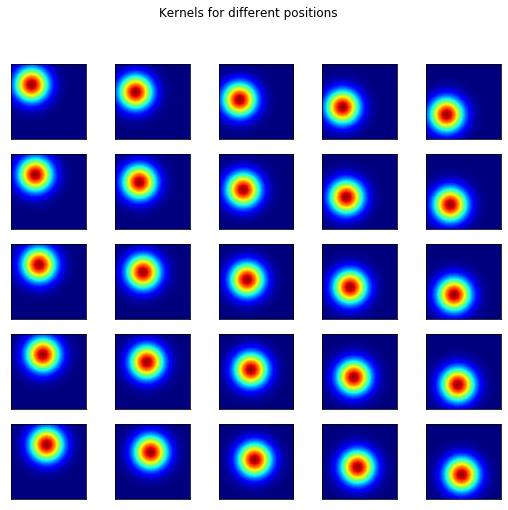

In [10]:
print('Minumum and Maximum lateral interaction: %.4f %.4f ' %(np.min(neural_field.lateral_interaction),
                                                              np.max(neural_field.lateral_interaction)))


if neural_field.border_type is None:
    size = field_size
else:
    size = field_size*2

# Plot the lateral interaction at different points in time
plt.figure(figsize=(13,8))
plt.suptitle('Lateral interaction over time')
for i in range(15):
    plt.subplot(3,5,i+1)
#     lat_int = neural_field.lateral_interaction[int(len(neural_field.lateral_interaction)/20*i)][0]
    lat_int = neural_field.lateral_interaction[20*i][0]
    plt.imshow(lat_int.reshape(field_size,field_size), cmap='jet', interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(ticks=[np.min(lat_int), np.max(lat_int)])
    
# Plot the sigmoid activation at the end
plt.figure()
plt.title('Sigmoided activation at the end')
plt.imshow(neural_field.example_sigmoid_activation[0], cmap='jet')
plt.xticks([])
plt.yticks([])
plt.colorbar(ticks=[np.min(neural_field.example_sigmoid_activation[0]), 
                     np.max(neural_field.example_sigmoid_activation[0])])



# Plot the kernels for different positions in the neural field
plt.figure(figsize=(9,8))
plt.suptitle('Kernels for different positions')
print('number of kernels:', len(neural_field.kernels[0]))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(neural_field.kernels[0][i*2].reshape(size,size), cmap='jet', 
               interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])

plt.show()